In [1]:
# -*- coding: utf-8 -*-

In [2]:
from __future__ import division
from IPython.display import Audio
%matplotlib inline
from IPython.display import display

In [3]:
%run "speechutils.py"
%run "viewutils.ipynb"

In [4]:
ch = callhome_eval_init("config.json", fast=False)
df_zrt, cols_to_show = ch.gen_zrt_df()

../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/master_graph.nodes
Loading prep state dictionary ...
Finished loading prep state dictionary ...
Finished ...
Finished - reading nodes ...
Processing line: 1
Finished - reading edges ...
Removing duplicates in pairs list
Set length: 19438 and List length: 43061
Generating vocabulary of English words ... 
Finished vocab ...
Generating initial belief over English translations
Processed 1 nodes
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Processing line: 1
Processing line: 3001
Processing line: 6001
Processing line: 9001
Processing line: 12001
Processing line: 15001
Processing line: 18001
Total matches: 19438
matches with missing transcriptions: 0
matches with only sil, sp: 8986
Finished - evaluating 19438 pairs ...
Setting up eval data frame
Finished ...
Savi

# Analyse ZRT output

### Set up visualizations

In [5]:
def display_pair_and_plot_dtw(pair_id, tosave=False, \
                              offset_1=(0,-1), \
                              offset_2=(0,-1), \
                              n_labels=("pair 1", "node 1", "node 2")):
    display(Audio(ch.play_pair_wav(pair_id)))

    pair_info = ch.eval_pairs_list[pair_id]
    node_1 = ch.node_dict[pair_info['n1']]
    node_2 = ch.node_dict[pair_info['n2']]


    wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
    wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

    es_words_1 = ch.es_words_dict[node_1.wav_fil]
    es_words_2 = ch.es_words_dict[node_2.wav_fil]
    #es_words_1 = ch.es_phones_dict[node_1.wav_fil]
    #es_words_2 = ch.es_phones_dict[node_2.wav_fil]
    #plot_name = "output/dtw_pair_1761_1762.pdf"
    # print(wav_1, wav_2)
    # print(es_words_1, es_words_2)
    wav_1_time = (node_1.start, node_1.end)
    wav_2_time = (node_2.start, node_2.end)
    plot_name = "output/{0:d}.pdf".format(pair_id)
    if not tosave:
        plot_name = ""
        
    plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
             wav_1_time, wav_2_time, pair_info['zrt_sim'], plot_name, \
             offset_1, offset_2, n_labels)

In [6]:
pd.options.display.float_format = '{:,.3f}'.format

In [7]:
display(df_zrt.head(1))
display(df_zrt[cols_to_show].head(1))
print(df_zrt.columns)

,chid1,chid2,cnt_es_w_check,ES cont match,dur,en_w_cnt_count_sim_0,EN sim,en_w_count_sim_0,en_w_hgr_sim_0,ES phone edit sim,...,n2,no_mtch,sil_only,uid1,uid2,ZRT,spk1,spk2,cross_spk,sim mixed
0,1,1,False,0,550,0,0.000,1,0.045,0.571,...,2,False,False,049.003,049.007,0.882,1.049.003,1.049.007,False,0.794


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
0,1,2,0.882,LíNEAS Y ESTABA,QUE ESTáN,0,0.571,0,0.000,0.794,1.049.003,1.049.007


Index([               u'chid1',                u'chid2',
             u'cnt_es_w_check',        u'ES cont match',
                        u'dur', u'en_w_cnt_count_sim_0',
                     u'EN sim',     u'en_w_count_sim_0',
             u'en_w_hgr_sim_0',    u'ES phone edit sim',
                u'ES words n1',          u'ES words n2',
              u'ES word match',                   u'n1',
                         u'n2',              u'no_mtch',
                   u'sil_only',                 u'uid1',
                       u'uid2',                  u'ZRT',
                       u'spk1',                 u'spk2',
                  u'cross_spk',            u'sim mixed'],
      dtype='object')


## Pairs discovered

### Filter Pairs

In [8]:
# Pairs with no matches in ES transcripts or only ['sil','sp'] matches
df_no_mtch_sil_only = df_zrt[(df_zrt['no_mtch'] == True) | (df_zrt['sil_only'] == True)]
# Pairs only ['sil','sp'] matches
df_sil_only = df_zrt[(df_zrt['sil_only'] == True)]
# Pairs with no matches in ES transcripts, but no ['sil','sp'] detected
df_no_mtch_not_sil = df_zrt[(df_zrt['no_mtch'] == True) & (df_zrt['sil_only'] == False)]

# Pairs with ES words found for both nodes
df_valid = df_zrt[(df_zrt['no_mtch'] == False) & (df_zrt['sil_only'] == False)]

# Filtering two files:
# df_valid = df_valid[df_valid.apply(lambda row: remove_invalid_files(row), axis=1)]
# df_valid = df_valid[df_valid['dur'] > 600]

# out_t = PrettyTable(["Description", "# of pairs"], hrules=True)
out_t = PrettyTable(["Description", "# of pairs"])
out_t.align['Description'] = 'r'
out_t.add_row(["Total pairs", len(df_zrt)])
out_t.add_row(["With sil, sp, or no matches", len(df_no_mtch_sil_only)])
out_t.add_row(["Pairs with speech segments and ES words", len(df_valid)])
print(out_t)
# print(out_t.get_html_string())
df_goodish = df_valid[(df_valid['ES word match']==1)]
df_cnt_goodish = df_valid[(df_valid['ES cont match']==1)]
df_xspk_goodish = df_valid[(df_valid['ES word match']==1) & (df_valid['cross_spk']==True)]
df_cnt_xspk_goodish = df_valid[(df_valid['ES cont match']==1) & (df_valid['cross_spk']==True)]
print(len(df_goodish), len(df_cnt_goodish))
print(len(df_xspk_goodish), len(df_cnt_xspk_goodish))


+-----------------------------------------+------------+
|                             Description | # of pairs |
+-----------------------------------------+------------+
|                             Total pairs |   19438    |
|             With sil, sp, or no matches |    8986    |
| Pairs with speech segments and ES words |   10452    |
+-----------------------------------------+------------+
(2316, 1304)
(662, 148)


In [9]:
_, _, _ = ch.eval_precision_recall(eval_col='es_w_sim', cross_spk=True)
_, _, _ = ch.eval_precision_recall(eval_col='es_w_sim', sim_col='sim mixed', cross_spk=True)

Computing precision recall, cross speaker = 1
# eval scores: 10452
# good scores: 662
#  bad scores: 9790
Average Precision - using sim: zrt_sim
----------------------------------------
	0.04702
----------------------------------------
Computing precision recall, cross speaker = 1
# eval scores: 10452
# good scores: 662
#  bad scores: 9790
Average Precision - using sim: sim mixed
----------------------------------------
	0.04832
----------------------------------------


Computing precision recall, cross speaker = 0
# eval scores: 10452
# good scores: 1304
#  bad scores: 9148
Average Precision - using sim: zrt_sim
----------------------------------------
	0.26868
----------------------------------------
Computing precision recall, cross speaker = 0
# eval scores: 10452
# good scores: 1304
#  bad scores: 9148
Average Precision - using sim: sim mixed
----------------------------------------
	0.48419
----------------------------------------


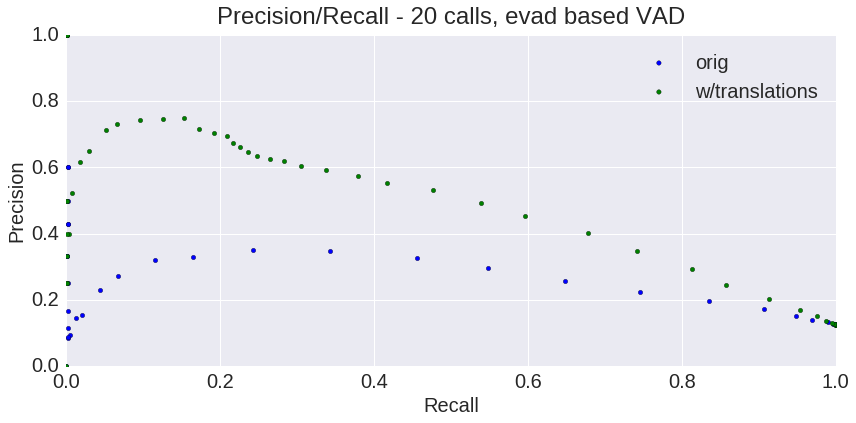

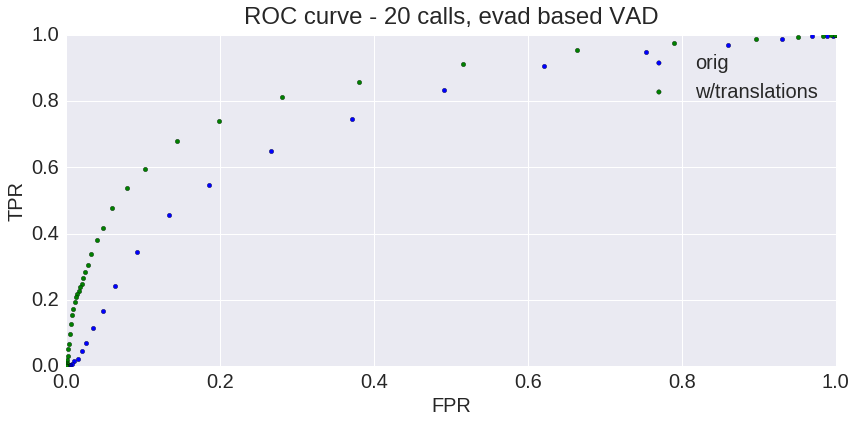

In [10]:
eval_col='cnt_es_w_sim'

fig_pr, fig_roc = ch.miniplot_precision_recall(eval_col=eval_col, cross_spk=False)
#fig_pr.suptitle("Precision/Recall - 50 calls, energy based VAD", fontsize=24, y=1.02)
fig_pr.gca().set_title("Precision/Recall - 20 calls, evad based VAD", \
                       fontsize=24, y=1.02)
fig_pr.tight_layout()
# fiig = plt.gcf()
fig_pr.savefig("output/train_20_evad_pr.pdf")
fig_roc.gca().set_title("ROC curve - 20 calls, evad based VAD", \
                        fontsize=24, y=1.02)
fig_roc.tight_layout()
fig_roc.savefig("output/train_20_evad_roc.pdf")

## Histogram - ZRT values

In [ ]:
df_valid[['ZRT']].plot(kind='hist', alpha=0.7)
df_valid[['sim mixed']].plot(kind='hist', alpha=0.7)
df_valid[['EN sim']].plot(kind='hist', alpha=0.7)

In [ ]:
df_valid[['dur']].plot(kind='hist', alpha=0.7, bins=200)

## Correlation between DTW and other metrics

In [ ]:
display(df_valid[['ZRT', 'EN sim']].corr())
display(df_valid[['ZRT', 'ES phone edit sim']].corr())
display(df_valid[['ZRT', 'ES cont match']].corr())
display(df_valid[['ZRT', 'ES word match']].corr())
display(df_valid[['ES phone edit sim', 'ES word match']].corr())

# Long matches

In [ ]:
long_dur_ms = 700
df_long_dur = df_valid[df_valid['dur'] >= long_dur_ms]
print("# of pairs with duration >= %dms : %d" % (long_dur_ms, len(df_long_dur)))
df_long_dur[cols_to_show].head(10)

In [ ]:
nodes_table = PrettyTable(["Node id", "Speech file", \
                           "Start time(ms)", \
                           "End time(ms)"])
transcripts_table = PrettyTable(["Node id", "ES words", \
                           "ES content words"])

scores_table = PrettyTable(["Pair id", "Node 1", "Node 2", "DTW score", "ES content word match"])


for i in range(1,5)+[27, 28, 61, 62, 64, 1761,1762]:
    nodes_table.add_row([i, ch.node_dict[i].wav_fil+".wav", ch.node_dict[i].start, \
                        ch.node_dict[i].end])
    #print((' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')))
    es_w = (' '.join(ch.node_dict[i].es_words).decode('utf-8'))
    if ch.node_dict[i].es_cnt_words:
        es_cnt_w = (' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')).strip()
    else:
        es_cnt_w = '---'
    #print(i, set(ch.node_dict[i].es_cnt_words) - set(['sil', 'sp']))
    es_w = es_w.replace('sil', '').replace('sp', '')
    es_cnt_w = es_cnt_w.replace('sil', '').replace('sp', '')
    transcripts_table.add_row([i, es_w, es_cnt_w])

found = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if found == 10:
        break
    if pair['cnt_es_w_sim'] > 0 or i<=2:
        scores_table.add_row([i, pair['n1'], pair['n2'], pair['zrt_sim'], pair['cnt_es_w_sim']])
        found += 1

print(nodes_table)
print(transcripts_table)
print(scores_table)
#print(' '.join(ch.node_dict[2].es_words))


display(ch.eval_pairs_list[1])
found = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['zrt_sim'] >= 0.88 and len(pair['es_w_n1'].split()) == 2 \
    and pair['en_w_hgr_sim_0'] == 0 \
    and pair['sil_only'] == False \
    and pair['es_w_n1'] != 'sil AS\xed':
        print(i, pair['n1'], pair['n2'], \
              pair['es_w_n1'].decode('utf-8'), pair['es_w_n2'].decode('utf-8'),\
             pair['cnt_es_w_sim'])
        found += 1
        if found == 50:
            break
print(found)

In [ ]:
display(Audio(ch.play_pair_wav(34)))
display(Audio(ch.play_pair_wav(5119)))

In [ ]:
display(ch.play_node_wav(619))
display(ch.play_node_wav(620))
display(ch.play_node_wav(45))
display(ch.play_node_wav(46))

node_1_file = ch.play_node_wav(1761)
node_2_file = ch.play_node_wav(1762)
display(node_1_file)
display(node_2_file)
# display(ch.play_node_source_wav(76605))

In [ ]:
plot_dtw(node_1_file, node_2_file)

21600
('Oi', 270.0)
((0.0, 4000.0), (0.0, 2.7000000000000002))
sil para decirle que me mande mi acta de bautismo sil
['to', 'tell', 'them', 'to', 'send', 'me', 'my', 'baptism', 'act']


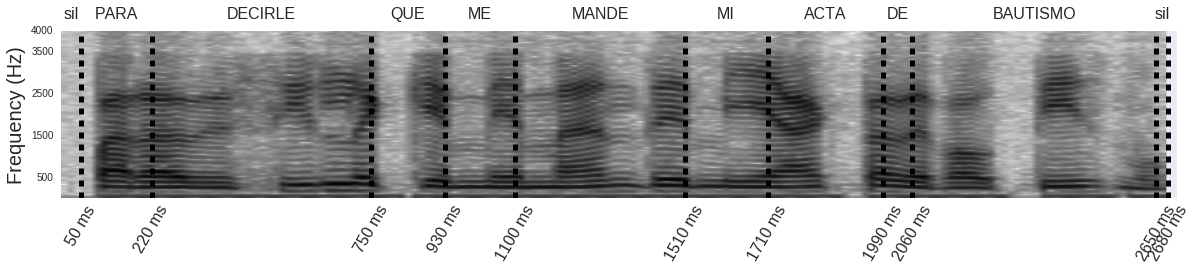

In [35]:
%run viewutils.ipynb
node_id = 1761

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1761.pdf"

plot_specgram_words(target_file, es_words, plot_name, offset=(0,10))

print(ch.en_words_dict[wav_file])

30240
('Oi', 378.0)
((0.0, 4000.0), (0.0, 3.7799999999999998))
sil este sp vamos a necesitar el papel del acta de bautismo sil
English translation:
we are going to need the sacrament of baptism paper


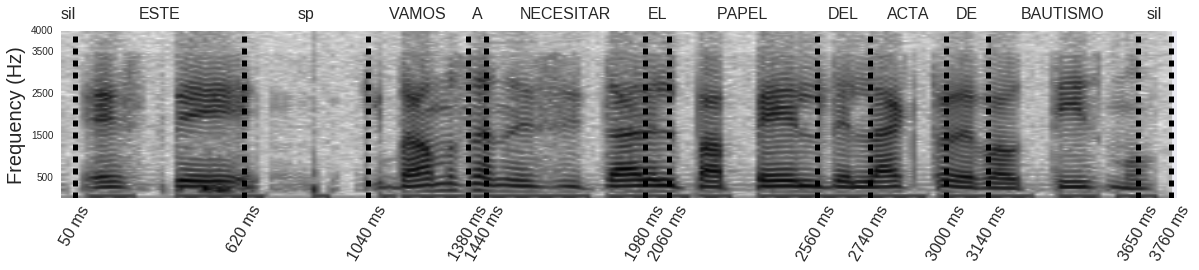

In [36]:
node_id = 1762

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1762.pdf"

plot_specgram_words(target_file, es_words, plot_name, offset=(0,12))

print("English translation:\n%s" % ' '.join(ch.en_words_dict[wav_file]))

In [ ]:
2680-1710

In [ ]:
display(Audio(ch.play_pair_wav(5118)))

In [ ]:
# %run viewutils.ipynb

# node_1 = ch.node_dict[1761]
# node_2 = ch.node_dict[1762]

# wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
# wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

# es_words_1 = ch.es_words_dict[node_1.wav_fil]
# es_words_2 = ch.es_words_dict[node_2.wav_fil]
# plot_name = "output/dtw_pair_1761_1762.pdf"
# # print(wav_1, wav_2)
# # print(es_words_1, es_words_2)
# wav_1_time = (node_1.start, node_1.end)
# wav_2_time = (node_2.start, node_2.end)
# plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
#          wav_1_time, wav_2_time, plot_name)

In [83]:
%run viewutils.ipynb

In [84]:
tosave=False

In [85]:
def plot_labels(n1_l, n2_l, dtw):
    ax = plt.gca()
    

Playing evaluation pair id: 5118
Pair text details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+---------+----------------------+-----------------------------------------------+
|   1761  | ACTA DE BAUTISMO sil |     to tell them to send me my baptism act    |
+---------+----------------------+-----------------------------------------------+
|   1762  | ACTA DE BAUTISMO sil | we are going to need the sacrament of baptism |
|         |                      |                     paper                     |
+---------+----------------------+-----------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.933       |
+-----------------

MI ACTA DE BAUTISMO sil
DEL ACTA DE BAUTISMO sil
DTW distance: 54.530782


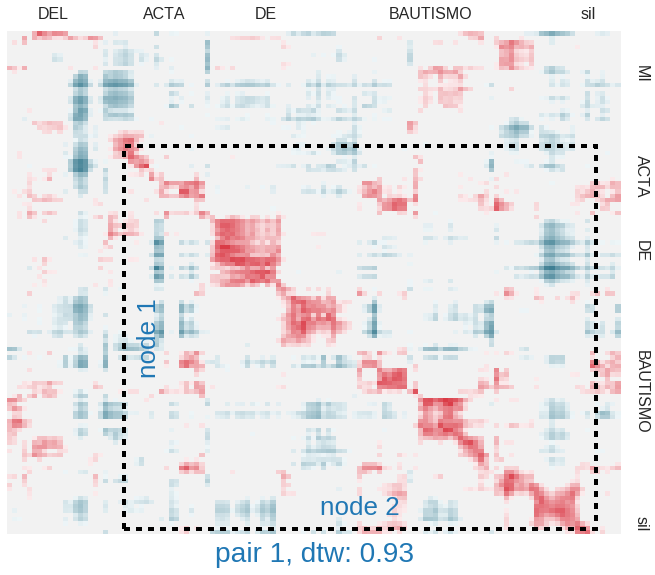

In [87]:
%run viewutils.ipynb
display_pair_and_plot_dtw(5118, tosave=tosave, \
                          offset_1=(6,None), \
                          offset_2=(8,None), \
                          n_labels=("pair 1", "node 1", "node 2"))

In [ ]:
display_pair_and_plot_dtw(15944, tosave=tosave, \
                          offset_1=(4,-2), \
                          offset_2=(3,-2), \
                          n_labels=("pair 2", "node 3", "node 4"))

In [ ]:
print(ch.en_w_cnt_belief[44099])
print(' & '.join([ch.i2w[w] for w in ch.en_w_cnt_belief[44099]]))
print(' & '.join(["{0:.2f}".format(b) for b in ch.en_w_cnt_belief[44099].values()]))

print([ch.i2w[w] for w in ch.en_w_cnt_belief[44100]])
print(["{0:.2f}".format(b) for b in ch.en_w_cnt_belief[44100].values()])

In [ ]:
display_pair_and_plot_dtw(16848, tosave=tosave, \
                          offset_1=(6,9), \
                          offset_2=(1,4), \
                          n_labels=("pair 3", "node 5", "node 6"))

print(ch.node_dict[44099].es_cnt_words)
print(ch.node_dict[44100].es_cnt_words)

In [ ]:
display_pair_and_plot_dtw(19326, tosave=tosave, \
                          offset_1=(0,3), \
                          offset_2=(0,3), \
                          n_labels=("pair 4", "node 7", "node 8"))

## Callhome 50, evad

In [ ]:
display_pair_and_plot_dtw(817, tosave=False)

### High phoneme score

In [ ]:
df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.6) \
                            & (df_valid['EN sim'] == 0)]
print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_hi[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score >= 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi[cols_to_show].head(5)

In [ ]:
display(Audio(ch.play_pair_wav(75)))

## Low phoneme score

In [ ]:
df_phone_score_0 = df_valid[(df_valid['ES phone edit sim'] == 0)]
print("Pairs with 0 phoneme similarity score: %d" % len(df_phone_score_0))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_0[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score = 0', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

** Analysis:** The plot shows a lot of high DTW score pairs where there is no match in the phonemes

In [ ]:
df_phone_score_0_high_dtw = df_phone_score_0[df_phone_score_0['ZRT'] > 0.87]
print("Pairs with high DTW and 0 phoneme similarity score: %d" % len(df_phone_score_0_high_dtw))

display(df_phone_score_0_high_dtw[cols_to_show].head(3))
# ch.play_pair_wav(28)

In [ ]:
df_phone_score_0_en_score_0 = df_phone_score_0[df_phone_score_0['EN sim'] == 0]
print("Pairs with 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_en_score_0))
# display(df_phone_score_0_en_score_0[cols_to_show][df_phone_score_0_en_score_0['ZRT'] < 0.82].head(3))
display(df_phone_score_0_en_score_0[cols_to_show].head(3))

df_phone_score_0_high_dtw_en_score_0 = df_phone_score_0_high_dtw[df_phone_score_0_high_dtw['EN sim'] == 0]
print("Pairs with high DTW and 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_high_dtw_en_score_0))
display(df_phone_score_0_high_dtw_en_score_0[cols_to_show].head(3))

In [ ]:
# display(ch.play_pair_wav(594, detail=True))
display(ch.play_pair_wav(52, detail=False))
# display(ch.play_node_source_wav(131))

In [ ]:
ch.file_info_dict["049.156"].source_file

In [ ]:
# !soxi ../../corpora/callhome_es/out/006.183.wav
# !play ../../corpora/callhome_es/out/006.183.wav trim 1.24
# IPython.display.Audio("../../corpora/callhome_es/out/tmp/sp_0731_1.wav")

### Conclusion

**Pairs with high DTW and 0 phoneme and 0 EN word similarity indicate transcription errors or coding errors**


**Need to investigate**

### High Phoneme similarity

In [ ]:
# df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
# print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_valid['ZRT'].hist(ax=ax, alpha=0.3)
df_phone_score_hi['ZRT'].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score > 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi_en_score_0 = df_phone_score_hi[(df_phone_score_hi['EN sim'] == 0) & \
                                                (df_phone_score_hi['spk1'] != df_phone_score_hi['spk2'])]
print("Pairs with high phoneme score and 0 EN sim: %d" % len(df_phone_score_hi_en_score_0))

df_phone_score_hi_en_score_0[cols_to_show].head(5)

In [ ]:
ch.play_pair_wav(70)

## High DTW score, Low EN translation similarity

These are expected to be phonetically similary but semantically different pairs.

**Label Spreading** should help **lower** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] == 0)].hist()
print(len(df_valid['ZRT'][(df_valid['EN sim'] == 0)]))

In [ ]:
df_high_dtw_0_en = df_valid[(df_valid['ZRT'] > 0.87) \
                            & (df_valid['EN sim'] >= 0.2) & \
                            (df_valid['spk1'] != df_valid['spk2'])]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_high_dtw_0_en))
df_high_dtw_0_en[cols_to_show].head(5)

In [ ]:
display(Audio(ch.play_pair_wav(105, detail=True)))

In [ ]:
# !play ../../corpora/callhome_es/out/001.202.wav trim .75 =.99

## Low DTW score, High EN translation similarity

These are expected to be semantically similar but phonetically not very similar.

**Label Spreading** should help **increase** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] >= 0.2)].hist()

In [ ]:
df_low_dtw_high_en = df_valid[(df_valid['ZRT'] < 0.88) & (df_valid['EN sim'] >= 0.2)]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_low_dtw_high_en))
df_low_dtw_high_en[cols_to_show].tail()

In [ ]:
display(Audio(ch.play_pair_wav(19326, detail=True)))

## Precision / Recall

In [ ]:
df_valid[cols_to_show].head()

In [ ]:
ch.eval_precision_recall()

In [ ]:
ch.eval_precision_recall(sim_col='sim mixed')

In [ ]:
ch.miniplot_precision_recall()

# fiig = plt.gcf()
# fiig.savefig("output/train_50_evad_avg_precision.pdf")
# fiig.savefig("output/train_50_evad_avg_precision.png")

## Cross-utterance matches

In [ ]:
set_speakers_calls = set()
spk1_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk1'].values]
spk2_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk2'].values]
set_speakers_calls |= set(spk1_ids)
set_speakers_calls |= set(spk2_ids)

num_speakers = len(set_speakers_calls)
cross_spk_counts = np.zeros((num_speakers, num_speakers), dtype=np.int)
label2i = {k:i for i, k in enumerate(set_speakers_calls)}
i2label = {i:k for i, k in enumerate(set_speakers_calls)}

lol = 0
for spk1, spk2 in zip(spk1_ids, spk2_ids):
    if spk1 != spk2:
        lol += 1
        cross_spk_counts[max(label2i[spk1], label2i[spk2]), min(label2i[spk1], label2i[spk2])] += 1
        cross_spk_counts[min(label2i[spk1], label2i[spk2]), max(label2i[spk1], label2i[spk2])] += 1
    else:
        cross_spk_counts[label2i[spk1], label2i[spk2]] += 1
        pass

print("Total speakers: %d" % num_speakers)
print(lol)

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    ax = sns.heatmap(cross_spk_counts, square=True, annot=False, \
                 fmt="d", linewidths=.5, cbar=False, xticklabels=2, yticklabels=2)
ax.xaxis.tick_top()
f.savefig("output/train_20_only_cross_spkrs.pdf")
f.savefig("output/train_20_only_cross_spkrs.png")

In [ ]:
# df_valid.columns
df_cross_spkr = df_valid[df_valid.apply(lambda row: True if row['spk1'].rsplit('.', 1)[0] != \
                        row['spk2'].rsplit('.', 1)[0] else False, \
                                    axis=1)]
print("# of cross-speaker pairs: %d" % (len(df_valid[df_valid['cross_spk'] == True])))
# display(df_valid[cols_to_show].head(5))
#df_cross_spkr['ZRT'].hist()
# df_valid['cross_spk'] = 
print(len(df_cross_spkr), len(df_valid))

In [ ]:
df_cross_spkr_bad_zrt_good_en = df_cross_spkr[(df_cross_spkr['ZRT'] <= 0.87)\
                                              & (df_cross_spkr['EN sim'] > 0.2)]
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr_bad_zrt_good_en)))
display(df_cross_spkr_bad_zrt_good_en[cols_to_show].head(10))

In [ ]:
display(Audio(ch.play_pair_wav(16848)))

## Speakers/utterances with most matches

In [ ]:
df_spkr_matches = df_valid.apply(lambda row: row['spk1'].rsplit('.', 1)[0] != \
                                   row['spk2'].rsplit('.', 1)[0], \
                                   axis=1)
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr)))
display(df_cross_spkr[cols_to_show].head(3))
df_cross_spkr['ZRT'].hist()

## s

## Label Spreading - speech pair similarity score update using English translations

In [ ]:
ch.label_prop_edges.label_spread(ch.en_w_hgr_sim_0)

In [ ]:
print(ch.label_prop_edges.belief_0[1])
print(ch.label_prop_edges.belief_n[1])
print(ch.en_w_hgr_sim_0[1], ch.en_w_hgr_sim_0[2])

In [ ]:
df_valid[cols_to_show].sort_values(['ZRT'], ascending=False)

In [ ]:
display(ch.play_pair_wav(84, detail=True))

In [ ]:
(0.9 * 0.8) + (0.1 * 0.7)

In [ ]:
df_valid.columns

In [ ]:
sns.jointplot(x='ZRT', y='ES cont match', data=df_valid, kind='kde')

In [ ]:
df_valid.columns

In [ ]:
%run viewutils.ipynb

In [ ]:
# plot_hist_dtw(df_valid, plot_name="output/train_20_energy_vad_hist.pdf")
plot_hist_dtw(df_valid, plot_name="output/train_20_transcript_vad_hist.pdf")

In [ ]:
%%timeit -n1 -r1
ch_eval.label_prop_en_words.label_spread(ch_eval.edges_dict)
print(ch_eval.edges_dict[1])
print(ch_eval.en_w_belief[1])
print(ch_eval.en_w_belief[2])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])

print(len(ch_eval.en_vocab))
print(sorted(ch_eval.en_words_stats.items(), reverse=True, key= lambda x: x[1])[:5])
print(ch_eval.en_w_sim_0[1])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])
print(ch_eval.label_prop_en_words.belief_0[2])
print(ch_eval.label_prop_en_words.belief_n[2])

Trying line plots for metrics

In [ ]:
pairs = pd.Series([0.69, 0.79, 0.37, 0.58, 0.268, 0.484, 0.144, 0.328])
cats = pd.Series(['20 evad: AP', '20 evad: AP w/translations', \
                  '50 evad: AP', '50 evad: AP w/translations', \
                  '20 vad: AP', '20 vad: AP w/translations', \
                  '50 vad: AP', '50 vad: AP w/translations'])
sns.barplot(x=pairs, y=cats, palette="Greens_d");

fig = plt.gcf()
fig.tight_layout()

fig.savefig("output/avgprecision.pdf")

In [ ]:
pairs = {}
pairs['A'] = {'config':'A', 'good':1, 'total':3}
pairs['B'] = {'config':'B', 'good':2, 'total':4}
testpd = pd.DataFrame.from_dict(pairs)
# sns.barplot(y='A', x='good', data=testpd)
testpd

In [ ]:
wav_name = "sp_0897.wav"
# IPython.display.Audio(wav_name)
sr1, y1 = scipy.io.wavfile.read(wav_name)
print(len(y1) / sr1, len(y1) / sr1 / 60.0)
!soxi $wav_name
mfcc1 = mfcc(y1, sr1)
print(mfcc1.shape)